In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.env_checker import check_env

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [2]:
def type_encoding(type):
        type_code = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E': 4, 'F' : 5, 'G' : 6, 'H' : 7, 'I' : 8, 'J' : 9, 'K' : 10, 'L' : 11, 'M' : 12, 'N' : 13, 'O' : 14, 'P' : 15, 'Q' : 16, 'R' : 17, 'S' : 18, 'T' : 19, 'U' : 20, 'V' : 21, 'W' : 22, 'X' : 23, 'Y' : 24, 'Z' : 25}
        return type_code[type]

In [3]:
class Resource():
    def __init__(self, resouces_dictionary):
        self.task_schedule = []  # (tasks)
        self.name = resouces_dictionary['name']
        self.ability = self.ability_encoding(
            resouces_dictionary['ability'])  # "A, B, C, ..."
        self.operation_rate = 0

    def __str__(self):
        # str_to_tasks = [str(task) for task in self.task_schedule]
        # return f"{self.name} : {str_to_tasks}"
        return f"{self.name}"
    def ability_encoding(self, ability):
        return [type_encoding(type) for type in ability]
    
    def can_process_task(self, task_type):
        return task_type in self.ability

In [4]:
class Order():
    def __init__(self, order_info):
        self.name = order_info['name']
        self.color = order_info['color']
        self.task_queue = [Task(task_info)
                           for task_info in order_info['tasks']]
        self.density = 0.0

        # changed : add deadline, time_exceeded
        self.deadline = order_info['deadline']
        self.time_exceeded = 0

In [5]:
class Task():
    def __init__(self, task_dictionary):
        self.sequence = task_dictionary['sequence']
        self.index = task_dictionary['index']
        self.type = type_encoding(task_dictionary['type'])
        self.predecessor = task_dictionary['predecessor']
        self.earliest_start = task_dictionary['earliest_start']
        self.duration = task_dictionary['duration']
        self.start = task_dictionary['start']
        self.finish = task_dictionary['finish']
        self.resource = -1
        self.color = ""
        self.order = -1

    def to_dict(self):
        return {
            'sequence': self.sequence,
            'index' : self.index,
            'type' : self.type,
            'predecessor' : self.predecessor,
            'earliest_start' : self.earliest_start,
            'duration' : self.duration,
            'start': self.start,
            'finish': self.finish,
            'resource': self.resource,
            'color' : self.color,
            'order' : self.order
        }
    def __str__(self):
        return f"order : {self.order}, step : {self.index} | ({self.start}, {self.finish})"

In [17]:
class SchedulingEnv(gym.Env):
    def _load_resources(self, file_path):
        resources = []

        with open(file_path, 'r') as file:
            data = json.load(file)

        for resource_data in data["resources"]:
            resource = {}
            resource['name'] = resource_data["name"]
            resource['ability'] = resource_data["type"].split(', ')
            resources.append(resource)

        return resources

    def _load_orders(self, file):
        # Just in case we are reloading tasks

        orders = []  # 리턴할 용도
        orders_new_version = []  # 파일 읽고 저장할 때 쓰는 용도
        f = open(file)

        # returns JSON object as  a dictionary
        data = json.load(f)
        f.close()
        orders_new_version = data['orders']

        for order in orders_new_version:
            order_info = {}
            # Initial index of steps within order
            order_info['name'] = order['name']
            order_info['color'] = order['color']
            # changed : add deadline
            order_info['deadline'] = order['deadline']
            earliestStart = order['earliest_start']

            tasks = []
            for task in order['tasks']:
                predecessor = task['predecessor']
                task_info = {}
                # Sequence is the scheduling order, the series of which defines a State or Node.
                task_info['sequence'] = None
                task_info['index'] = task['index']
                task_info['type'] = task['type']
                if predecessor is None:
                    task_info['predecessor'] = None
                    task_info['earliest_start'] = earliestStart
                else:
                    task_info['predecessor'] = predecessor
                    task_info['earliest_start'] = None
                task_info['duration'] = task['duration']
                task_info['start'] = None
                task_info['finish'] = None

                tasks.append(task_info)

            order_info['tasks'] = tasks
            orders.append(order_info)

        return orders

    def __init__(self, resources="../resources/v2-8.json", orders="../orders/v2-12-deadline-updated.json", render_mode="seaborn"):
        super(SchedulingEnv, self).__init__()

        resources = self._load_resources(resources)
        orders = self._load_orders(orders)
        self.resources = [Resource(resource_info)
                          for resource_info in resources]
        self.orders = [Order(order_info) for order_info in orders]
        len_resources = len(self.resources)
        len_orders = len(self.orders)
        # Reset 할 때 DeepCopy를 위해 원본을 저장해둠
        self.original_orders = copy.deepcopy(self.orders)
        self.original_resources = copy.deepcopy(self.resources)
        self.original_tasks = copy.deepcopy(
            [order.task_queue for order in self.orders])
        self.num_tasks = sum([len(order.task_queue) for order in self.orders])

        self.schedule_buffer = [-1 for _ in range(len(self.orders))]
        # 4 : 각 리소스별 task 수 최댓값
        self.original_order_details = np.ones(
            (len_orders, 4, 2), dtype=np.int8) * -1
        for o in range(len_orders):
            for t in range(len(self.orders[o].task_queue)):
                self.original_order_details[o][t][0] = int(
                    self.orders[o].task_queue[t].duration // 100)
                self.original_order_details[o][t][1] = int(
                    self.orders[o].task_queue[t].type)
        self.current_order_details = copy.deepcopy(self.original_order_details)

        self.order_state = None
        self.resource_types = None
        self.operation_schedules = None
        # self.action_space = spaces.MultiDiscrete([len_resources, len_orders])
        self.action_space = spaces.Discrete(len_resources * len_orders)
        self.action_mask = np.ones(
            shape=(len(self.resources) * len(self.orders)), dtype=bool)
        self.legal_actions = np.ones(
            shape=(len(self.resources), len(self.orders)), dtype=bool)

        self.observation_space = spaces.Dict({
            "action_mask": spaces.Box(low=0, high=1, shape=(len_resources * len_orders, ), dtype=np.int8),
            "order_details": spaces.Box(low=-1, high=25, shape=(len_orders, 4, 2), dtype=np.int8),
            'order_density': spaces.Box(low=0, high=1, shape=(len_orders, ), dtype=np.float64),
            'order_deadline': spaces.Box(low=0, high=3000, shape=(len_orders, ), dtype=np.int64),
            'resource_operation_rate': spaces.Box(low=0, high=1, shape=(len_resources, ), dtype=np.float64),
            "num_task_per_resource": spaces.Box(low=0, high=100, shape=(len_resources, ), dtype=np.int64),
            "resource_types": spaces.Box(low=0, high=1, shape=(len_resources, 25), dtype=np.int8),
            "operation_schedules": spaces.Box(low=0, high=1, shape=(len_resources, 50), dtype=np.int8),
            "resource_operation_rate" : spaces.Box(low=-1, high=1, shape=(len_resources, ), dtype=np.float64),
        })

        self.current_schedule = []
        self.num_scheduled_tasks = 0
        self.num_steps = 0
        self.invalid_count = 0
        self.last_finish_time = 0
        self.valid_count = 0

    def reset(self, seed=None, options=None):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """
        super().reset(seed=seed, options=options)

        # 환경과 관련된 변수들
        self.orders = copy.deepcopy(self.original_orders)
        self.resources = copy.deepcopy(self.original_resources)

        self.current_order_details = copy.deepcopy(self.original_order_details)

        # 내부 동작을 위한 변수들
        # self.order_state 관한 추가설명 / Order 하나 당 가지는 정보는 아래와 같다
        # 1. 남은 task 수
        # 2. 다음으로 수행할 Task의 Type
        # 3. 다음으로 수행할 Task의 earliest_start
        # 4. 다음으로 수행할 Task의 duration
        # self.order_state = np.zeros((len(self.orders), 4), dtype=np.int32)
        self.resource_types = np.zeros(
            (len(self.resources), 25), dtype=np.int8)
        self.operation_schedules = np.zeros(
            (len(self.resources), 50), dtype=np.int8)

        self.legal_actions = np.ones(
            (len(self.resources), len(self.orders)), dtype=bool)
        self.action_mask = np.ones(
            (len(self.resources) * len(self.orders)), dtype=bool)

        self._update_state(None)

        # 기록을 위한 변수들
        self.current_schedule = []
        self.num_scheduled_tasks = 0
        self.num_steps = 0
        self.invalid_count = 0
        self.last_finish_time = 0
        self.valid_count = 0

        return self._get_observation(), self._get_info()  # empty info dict

    def step(self, action):
        # if action[0] < 0 or action[1] < 0 or action[0] >= len(self.resources) or action[1] >= len(self.orders):
        #     raise ValueError(
        #         f"Received invalid action={action} which is not part of the action space"
        #     )
        if action < 0 or action >= len(self.resources) * len(self.orders):
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        # Map the action to the corresponding resource and order
        selected_resource = action // len(self.orders)
        selected_order = action % len(self.orders)
        action = [selected_resource, selected_order]

        # error_action이 아니라면 step의 수를 증가시킨다
        self.num_steps += 1
        self._update_legal_actions()
        reward = 0

        if self.legal_actions[action[0]][action[1]]:
            self._update_state(action)
            reward = self._calculate_step_reward()
        else:  # Illegal action
            self.invalid_count += 1
            reward = -1

        # 모든 Order의 Task가 종료된 경우 Terminated를 True로 설정한다
        # 또한 legal_actions가 전부 False인 경우도 Terminated를 True로 설정한다
        terminated = all([order.task_queue[-1].finish is not None for order in self.orders]
                         ) or not np.any(self.legal_actions)

        if terminated:
            self._get_final_reward()

        # reward += sum([task.duration for task in self.current_schedule]) / self._get_final_task_finish()
        # 무한 루프를 방지하기 위한 조건
        truncated = bool(self.num_steps == 10000)

        return (
            self._get_observation(),
            reward,
            terminated,
            truncated,
            self._get_info(),
        )

    def _get_info(self):
        return {
            'finish_time': self.last_finish_time,
            'legal_actions': self.legal_actions,
            'action_mask': self.action_mask,
            'order_details': self.current_order_details,
            'order_deadline' : [order.deadline for order in self.orders],
            'order_time_exceeded' : [order.time_exceeded for order in self.orders],
            'invalid_count': self.invalid_count,
            'resources_operation_rate': [resource.operation_rate for resource in self.resources],
            'orders_density': [order.density for order in self.orders],
            'schedule_buffer': self.schedule_buffer,
            'current_schedule': self.current_schedule
        }

    def action_masks(self):
        self._update_legal_actions()
        self.action_mask = self.legal_actions.flatten()
        return self.action_mask

    def _update_state(self, action=None):
        if action is not None:
            self.valid_count += 1
            self._schedule_task(action)
            self._update_schedule_buffer(action[1])
            # self._update_order_state(action)
            self._update_order_details(action[1])
            self._update_resource_state()
            self.last_finish_time = self._get_final_task_finish()
        else:
            self._update_schedule_buffer(None)
            # self._update_order_state(None)
            self._update_resource_state(init=True)

    def _update_legal_actions(self):
        # Initialize legal_actions
        self.legal_actions = np.ones(
            (len(self.resources), len(self.orders)), dtype=bool)

        for order_index in range(len(self.orders)):
            # 1. 선택된 Order의 모든 Task가 이미 종료된 경우
            if self.schedule_buffer[order_index] < 0:
                self.legal_actions[:, order_index] = False

        for resource_index in range(len(self.resources)):
            # 2. 선택된 Resource가 선택된 Order의 Task의 Type을 처리할 수 없는 경우
            resource = self.resources[resource_index]
            for order_index in range(len(self.orders)):
                order = self.orders[order_index]
                task = order.task_queue[self.schedule_buffer[order_index]]
                if not resource.can_process_task(task.type):
                    self.legal_actions[resource_index, order_index] = False

    def _update_order_details(self, order_index):
        selected_order = self.orders[order_index]

        sum_operation_duration = 0
        performed_tasks = []
        for t, task in enumerate(selected_order.task_queue):
            if task.finish is not None:  # task is already scheduled
                self.current_order_details[order_index][t][0] = -1
                self.current_order_details[order_index][t][1] = -1
                sum_operation_duration += task.duration
                performed_tasks.append(task)

        if len(performed_tasks) > 1:
            order_duration = performed_tasks[-1].finish - \
                performed_tasks[0].start
            selected_order.density = sum_operation_duration / order_duration

        if len(performed_tasks) == len(selected_order.task_queue):
            if selected_order.deadline < selected_order.task_queue[-1].finish:
                selected_order.time_exceeded = selected_order.task_queue[-1].finish - selected_order.deadline

    # def _update_order_state(self, action=None):
    #     # state는 order의 수 * 4의 행렬이다
    #     # 각 열에는 해당 Order의 Task에 대한 정보가 담겨있다
    #     # 남은 task 수
    #     # 다음으로 수행할 Task의 Duration
    #     # 다음으로 수행할 Task의 Earlist_start
    #     # 다음으로 수행할 Task의 Type
    #     for i, order in enumerate(self.orders):
    #         task_index = self.schedule_buffer[i]
    #         if task_index < 0:
    #             self.order_state[i] = np.zeros(4, dtype=np.int32)
    #         else:
    #             task = order.task_queue[task_index]
    #             self.order_state[i] = [len(order.task_queue) - task_index,
    #                                    task.duration, task.earliest_start, task.type]

        # if action is not None:
        #     # Order별 점수를 업데이트
            # order_gap = 0

            # selected_order = self.orders[action[1]]
            # performed_tasks = [
            #     task for task in selected_order.task_queue if task.finish is not None]
            # sum_performed_duration = 0
            # for task in performed_tasks:
            #     sum_performed_duration += task.duration
            # if len(performed_tasks) >= 2:
            #     # 주문의 수행된 Task 사이의 간격을 계산하여 Hall 리워드에 더합니다.
            #     for i in range(1, len(performed_tasks)):
            #         gap = performed_tasks[i].start - \
            #             performed_tasks[i - 1].finish
            #         order_gap += gap

            # selected_order.density = (sum_performed_duration -
            #                           order_gap)/sum_performed_duration

    # change : action argument 안씀 제거

    def _update_resource_state(self, init=False):
        if init:
            for i, resource in enumerate(self.resources):
                self.resource_types[i] = [
                    1 if i in resource.ability else 0 for i in range(25)]
            return

        for i, resource in enumerate(self.resources):
            operation_schedule = resource.task_schedule
            self.operation_schedules[i] = self._schedule_to_array(
                operation_schedule)

        # Resource의 reward를 계산
        for resource in self.resources:
            result = 0
            # 선택된 리소스의 스케줄링된 Task들
            if resource.task_schedule:
                scheduled_tasks = sorted(
                    resource.task_schedule, key=lambda task: task.start)
                # resource의 hall은 현재까지 스케줄에서 가장 늦게 끝난 Task를 기준으로 설계를 한다.
                # 현재까지 스케줄에서 가장 늦게 끝난 Task의 시간을 전체 길이로 보고
                # 막대가 분배되지 않은 부분들을 전부 Hall로 보고 계산한다.
                idle_time = scheduled_tasks[0].start + (self._get_final_task_finish() - scheduled_tasks[-1].finish)
                if len(scheduled_tasks) >= 2:
                    # 리소스의 스케줄링된 Task 사이의 간격을 계산하여 Hall 리워드에 더합니다.
                    for i in range(1, len(scheduled_tasks)):
                        gap = scheduled_tasks[i].start - scheduled_tasks[i - 1].finish
                        idle_time += gap
                result = (self._get_final_task_finish() - idle_time) / self._get_final_task_finish()
            resource.operation_rate = result
            
    def _schedule_to_array(self, operation_schedule):
        idle_time = []

        for task in operation_schedule:
            idle_time.append((task.start // 100, task.finish // 100))

        def is_in_idle_time(time):
            for interval in idle_time:
                if interval[0] <= time < interval[1]:
                    return True
            return False

        result = []

        for i in range(50):
            result.append(is_in_idle_time(i))

        return result

    def _update_schedule_buffer(self, target_order=None):
        # target_order은 매번 모든 Order를 보는 계산량을 줄이기 위해 설정할 변수
        # None은 최초의 호출에서, 또는 Reset이 이뤄질 경우를 위해 존재
        if target_order == None:
            buffer_index = 0

            for order in self.orders:
                # Assume order['steps'] is a list of tasks for the current order

                selected_task_index = -1

                for i in range(len(order.task_queue)):
                    # 아직 스케줄링을 시작하지 않은 Task를 찾는다
                    if order.task_queue[i].finish is None:
                        selected_task_index = i
                        break
                # 스케줄링 하지 않은 Task를 발견했다면
                if selected_task_index >= 0:
                    selected_task = order.task_queue[selected_task_index]

                    # 만약 초기 시작 제한이 없다면
                    # 초기 시작 제한을 이전 Task의 Finish Time으로 걸어주고 버퍼에 등록한다.
                    if selected_task.earliest_start is None:
                        if selected_task_index > 0:
                            selected_task.earliest_start = order.task_queue[selected_task_index-1].finish

                self.schedule_buffer[buffer_index] = selected_task_index
                buffer_index += 1

        # Action으로 인해 봐야할 버퍼의 인덱스가 정해짐
        else:
            selected_task_index = -1
            order = self.orders[target_order]
            for i in range(len(order.task_queue)):
                # 아직 스케줄링을 시작하지 않은 Task를 찾는다
                if order.task_queue[i].finish is None:
                    selected_task_index = i
                    break
            if selected_task_index >= 0:
                selected_task = order.task_queue[selected_task_index]
                if selected_task.earliest_start is None:
                    if selected_task_index > 0:
                        selected_task.earliest_start = order.task_queue[selected_task_index-1].finish

            self.schedule_buffer[target_order] = selected_task_index

    def _schedule_task(self, action):
        # Implement the scheduling logic based on the action
        # You need to update the start and finish times of the tasks
        # based on the selected task index (action) and the current state.

        # Example: updating start and finish times
        selected_resource = self.resources[action[0]]
        selected_order = self.orders[action[1]]
        selected_task = selected_order.task_queue[self.schedule_buffer[action[1]]]
        task_earliest_start = selected_task.earliest_start
        task_index = selected_task.index
        task_duration = selected_task.duration
        resource_tasks = sorted(
            selected_resource.task_schedule, key=lambda task: task.start)

        open_windows = []
        start_window = 0
        last_alloc = 0

        for scheduled_task in resource_tasks:
            resource_init = scheduled_task.start

            if resource_init > start_window:
                open_windows.append([start_window, resource_init])
            start_window = scheduled_task.finish

            last_alloc = max(last_alloc, start_window)

        # Fit the task within the first possible window
        window_found = False
        if task_earliest_start is None:
            task_earliest_start = 0

        for window in open_windows:
            # Task could start before the open window closes
            if task_earliest_start <= window[1]:
                # Now let's see if it fits there
                potential_start = max(task_earliest_start, window[0])
                if potential_start + task_duration <= window[1]:
                    # Task fits into the window
                    min_earliest_start = potential_start
                    window_found = True
                    break

        # If no window was found, schedule it after the end of the last task on the resource
        if not window_found:
            if task_earliest_start > 0:
                min_earliest_start = max(task_earliest_start, last_alloc)
            else:
                min_earliest_start = last_alloc

        # schedule it
        selected_task.sequence = self.num_scheduled_tasks + 1
        selected_task.start = min_earliest_start
        selected_task.finish = min_earliest_start + task_duration
        selected_task.resource = action[0]

        # 사실 여기서 color랑 order를 주는건 적절치 않은 코드임!!!!
        selected_task.color = self.orders[action[1]].color
        selected_task.order = action[1]

        self.current_schedule.append(selected_task)
        selected_resource.task_schedule.append(selected_task)
        self.num_scheduled_tasks += 1
        return

    def _get_final_task_finish(self):
        return max(self.current_schedule, key=lambda x: x.finish).finish

    def _calculate_step_reward(self, resources_weight = 0.5, orders_weight = 0.5):
        step_reward_by_resources = np.mean([resource.operation_rate for resource in self.resources])
        step_reward_by_orders = np.mean([order.density for order in self.orders])
        
        return resources_weight * step_reward_by_resources + orders_weight * step_reward_by_orders

    def _get_final_reward(self, weight_final_time = 80, weight_op_rate = 0, weight_order_deadline = 20):
        def final_time_to_reward(target_time):
            if target_time >= self._get_final_task_finish():
                return 1
            # Final_time이 target_time에 비해 몇 퍼센트 초과되었는지를 바탕으로 100점 만점으로 환산하여 점수 계산
            return max(0, 1 - (abs(target_time - self._get_final_task_finish()) / target_time))
        
        def operation_rate_to_reward(operation_rates, target_rate=1.0, penalty_factor=2.0):
            total_reward = 0
            for rate in operation_rates:
                # Operation rate가 목표에 가까울수록 보상을 증가시킴
                reward = 2/(abs(rate - target_rate) - 2) + 2
                # Operation rate의 차이에 따라 패널티를 부여함
                penalty = penalty_factor * abs(rate - target_rate)
                # 보상에서 패널티를 빼서 최종 보상을 계산함
                total_reward += reward - penalty
            return max(0, total_reward / len(self.resources))
        
        def order_deadline_to_reward():
            sum_of_late_rate = 0
            for order in self.orders:
                if order.time_exceeded > 0:
                    sum_of_late_rate += (order.time_exceeded / order.deadline)
            return max(0, 1 - sum_of_late_rate)

        final_reward_by_op_rate = weight_op_rate * operation_rate_to_reward([resource.operation_rate for resource in self.resources])
        final_reward_by_final_time = weight_final_time * final_time_to_reward(1000) 
        final_reward_by_order_deadline = weight_order_deadline * order_deadline_to_reward()

        return final_reward_by_op_rate + final_reward_by_final_time + final_reward_by_order_deadline

    def _get_observation(self):
        observation = {
            'action_mask': self.action_masks(),
            'order_details': self.current_order_details,
            'order_density' : np.array([order.density for order in self.orders]),
            'order_deadline': np.array([order.deadline for order in self.orders]),
            'resource_operation_rate': np.array([resource.operation_rate for resource in self.resources]),
            'num_task_per_resource': np.array([len(resource.task_schedule) for resource in self.resources]),
            'resource_types': self.resource_types,
            'operation_schedules': self.operation_schedules,
            'resource_operation_rate' : np.array([resource.operation_rate for resource in self.resources])
        }

        return observation

    def render(self, mode="seaborn"):
        if mode == "console":
            # You can implement console rendering if needed
            pass
        elif mode == "seaborn":
            return self._render_seaborn()
        elif mode == "rgb_array":
            return self._render_rgb_array()

    def _render_seaborn(self):
        fig = self._make_chart()
        plt.show()

    def _render_rgb_array(self):
        # Render the figure as an image
        fig = self._make_chart()
        canvas = FigureCanvasAgg(plt.gcf())
        canvas.draw()

        # Convert the image to RGB array
        buf = canvas.buffer_rgba()
        width, height = canvas.get_width_height()
        rgb_array = np.frombuffer(
            buf, dtype=np.uint8).reshape((height, width, 4))

        return rgb_array

    def _make_chart(self):
        # Create a DataFrame to store task scheduling information
        current_schedule = [task.to_dict() for task in self.current_schedule]

        scheduled_df = list(
            filter(lambda task: task['sequence'] is not None, current_schedule))
        scheduled_df = pd.DataFrame(scheduled_df)

        if scheduled_df.empty:
            # Create an empty chart
            plt.figure(figsize=(12, 6))
            plt.title("Task Schedule Visualization")
            return plt

        # Create a bar plot using matplotlib directly
        fig, ax = plt.subplots(figsize=(12, 6))
        legend_orders = set()  # Set to store orders already included in the legend

        for i in range(len(self.resources)):
            resource_tasks = scheduled_df[scheduled_df['resource'] == i]

            # Discriminate rows by lines
            line_offset = i - 0.9  # Adjust the line offset for better visibility

            for index, task in resource_tasks.iterrows():
                order_label = f'Order {int(task["order"])}'
                if order_label not in legend_orders:
                    legend_orders.add(order_label)
                else:
                    order_label = None

                ax.bar(
                    # Adjust 'x' to start from 'start'
                    x=task["start"] + task["duration"] / 2,
                    height=0.8,  # Height of the bar
                    width=task["duration"],  # Width of the bar
                    bottom=line_offset,  # Discriminate rows by lines
                    color=task['color'],
                    alpha=0.7,  # Transparency
                    label=order_label,  # Label for the legend
                )

        # Set y-axis ticks to show every resource
        ax.set_yticks(np.arange(0, len(self.resources)))
        ax.set_yticklabels(self.resources)

        ax.set(ylabel="Resource", xlabel="Time")
        # Place the legend outside the plot area
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.title("Task Schedule Visualization")
        # 경고 무시 설정
        plt.rcParams['figure.max_open_warning'] = 0

        return fig

    def close(self):
        pass

In [18]:
env = SchedulingEnv()
check_env(env)

In [19]:
model = PPO('MultiInputPolicy', env, verbose=1).learn(1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 214      |
|    ep_rew_mean     | -163     |
| time/              |          |
|    fps             | 1559     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 223        |
|    ep_rew_mean          | -172       |
| time/                   |            |
|    fps                  | 1272       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01327524 |
|    clip_fraction        | 0.218      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.55

In [ ]:
obs, info = env.reset()
done = False
while True:
    action, _ = model.predict(obs, deterministic = False)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print(f"Final task finish time : {info['finish_time']}")
        print(info['invalid_count'])
        print(info['resources_operation_rate'])
        print(info['orders_density'])

        env.render()
        break

In [ ]:
sum_finish = 0
min_finish = 10000
for _ in range(1000):
    obs, info = env.reset()
    done = False

    while True:
        action, _ = model.predict(obs, deterministic = False)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if terminated:
            sum_finish += info['finish_time']
            if min_finish > info['finish_time']:
                min_finish = info['finish_time']
            break
            
print(sum_finish / 1000)
print(min_finish)

Final task finish time : 2300
191
[0.21739130434782608, 0.17391304347826086, 0.5652173913043478, 0.5217391304347826, 0.43478260869565216, 0.8695652173913043, 0.391304347826087, 0.2608695652173913]
[1.5333333333333332, 3.0, 3.0, -2.5, 3.0, 2.6666666666666665, 3.0, 2.9, -2.0666666666666664, 3.0, 3.0, 3.0]


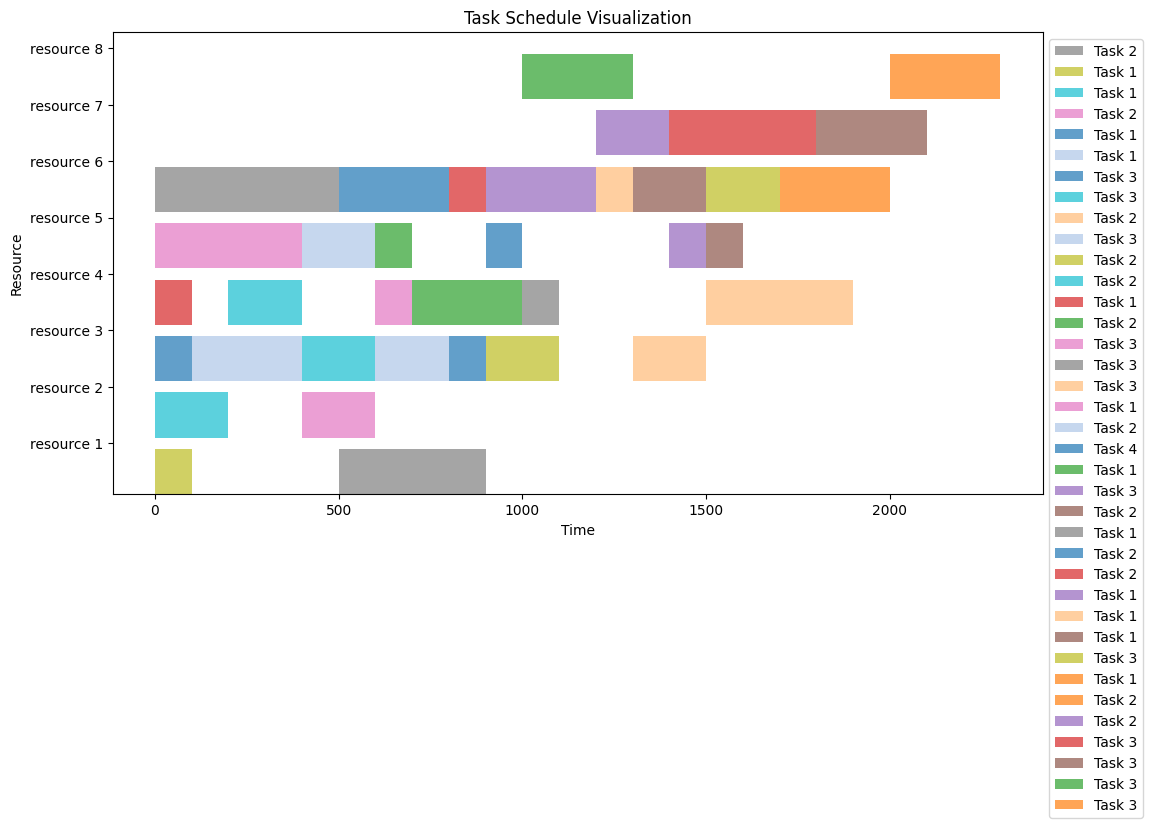

In [97]:
step = 0
obs, _ = env.reset()

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print(f"Final task finish time : {info['finish_time']}")
        print(info['invalid_count'])
        print(info['resources_operation_rate'])
        print(info['orders_density'])
        env.render()
        break

In [98]:
sum_finish = 0

for _ in range(1000):
    obs, info = env.reset()
    done = False

    while True:
        step += 1
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            sum_finish += info['finish_time']
            break
            
print(sum_finish / 1000)

2050.8


In [101]:
model.save("PPO_2,000,000_MIP_v1")

In [18]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.envs import InvalidActionEnvDiscrete
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib.common.wrappers import ActionMasker

In [19]:
def mask_fn(env: gym.Env):
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.get_action_mask()

In [20]:
env = ActionMasker(env, mask_fn)

In [ ]:
obs, info = env.reset()
done = False
episode_reward = 0

while True:
    action_masks = get_action_masks(env)
    action, _states = model.predict(obs, action_masks=action_masks)

    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    episode_reward += reward
    if done:
        print(f"Episode reward: {episode_reward}")
        print(f"Final task finish time : {info['finish_time']}")
